In [ ]:
import torch
from diffusers import LDMPipeline, UNet2DModel, VQModel, DDIMScheduler
import torch.nn.utils.prune as prune

# Load the pretrained models and scheduler
unet = UNet2DModel.from_pretrained("CompVis/ldm-celebahq-256", subfolder="unet")
vqvae = VQModel.from_pretrained("CompVis/ldm-celebahq-256", subfolder="vqvae")
scheduler = DDIMScheduler.from_config("CompVis/ldm-celebahq-256", subfolder="scheduler")

def prune_unet(unet_model, amount=0.3):
    """
    Applies pruning to the U-Net model's convolutional layers and returns the pruned model.

    Parameters:
        unet_model (nn.Module): The U-Net model to prune.
        amount (float): The proportion of weights to prune in each layer (0 < amount < 1).

    Returns:
        nn.Module: The pruned U-Net model.
    """
    for name, module in unet_model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            prune.l1_unstructured(module, name='weight', amount=amount)
            print(f"Pruned layer: {name} - amount: {amount}")

    for name, module in unet_model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            prune.remove(module, 'weight')
            print(f"Removed pruning reparameterization for layer: {name}")

    # Return the pruned model
    return unet_model

def calculate_sparsity(model):
    total_params = 0
    zero_params = 0
    for name, param in model.named_parameters():
        if 'weight' in name:
            total_params += param.numel()
            zero_params += (param == 0).sum().item()
    sparsity = 100.0 * zero_params / total_params
    print(f"Sparsity: {sparsity:.2f}%")
    print(f"Total Parameters: {total_params}, Zeroed Parameters: {zero_params}")

calculate_sparsity(unet)

unet = prune_unet(unet, amount=0.3)
vqvae = prune_unet(vqvae, amount=0.3)

pipeline = LDMPipeline(
    unet=unet,
    vqvae=vqvae,
    scheduler=scheduler,
).to("cuda" if torch.cuda.is_available() else "cpu")

torch.save(unet.state_dict(), "pruned_unet_celebahq.pth")
print("Pruned model saved as pruned_unet_celebahq.pth")

calculate_sparsity(unet)
calculate_sparsity(vqvae)


2024-10-31 14:25:03.493504: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-31 14:25:03.524806: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-31 14:25:03.524836: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-31 14:25:03.525615: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-31 14:25:03.531341: I tensorflow/core/platform/cpu_feature_guar

Sparsity: 0.00%
Total Parameters: 273915936, Zeroed Parameters: 0
Pruned layer: conv_in - amount: 0.3
Pruned layer: down_blocks.0.resnets.0.conv1 - amount: 0.3
Pruned layer: down_blocks.0.resnets.0.conv2 - amount: 0.3
Pruned layer: down_blocks.0.resnets.1.conv1 - amount: 0.3
Pruned layer: down_blocks.0.resnets.1.conv2 - amount: 0.3
Pruned layer: down_blocks.0.downsamplers.0.conv - amount: 0.3
Pruned layer: down_blocks.1.resnets.0.conv1 - amount: 0.3
Pruned layer: down_blocks.1.resnets.0.conv2 - amount: 0.3
Pruned layer: down_blocks.1.resnets.0.conv_shortcut - amount: 0.3
Pruned layer: down_blocks.1.resnets.1.conv1 - amount: 0.3
Pruned layer: down_blocks.1.resnets.1.conv2 - amount: 0.3
Pruned layer: down_blocks.1.downsamplers.0.conv - amount: 0.3
Pruned layer: down_blocks.2.resnets.0.conv1 - amount: 0.3
Pruned layer: down_blocks.2.resnets.0.conv2 - amount: 0.3
Pruned layer: down_blocks.2.resnets.0.conv_shortcut - amount: 0.3
Pruned layer: down_blocks.2.resnets.1.conv1 - amount: 0.3
Prun

  0%|          | 0/200 [00:00<?, ?it/s]

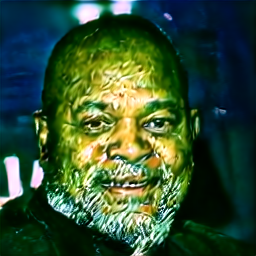

In [ ]:
from IPython.display import display

# Define batch size and prompt
batch_size = 1

# Run the pipeline with the specified batch size
with torch.no_grad():
    generated_images = pipeline(batch_size=batch_size, num_inference_steps=100)

# Assuming `generated_images` is the output from the pipeline
generated_images_list = generated_images.images
display(generated_images_list[0])


In [ ]:
import os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from diffusers import LDMPipeline, UNet2DModel, VQModel, DDIMScheduler
import torch.nn.utils.prune as prune
from tqdm import tqdm
import torch.nn.functional as F
from IPython.display import display

# ============================
# 1. Configuration Parameters
# ============================

# Paths
DATASET_PATH = "dataset/celeba_hq_test"
PRUNED_UNET_PATH = "pruned_unet_celebahq.pth"
PRUNED_VQVAE_PATH = "pruned_vqvae_celebahq.pth"
FINE_TUNED_UNET_PATH_TEMPLATE = "run/finetuned/fine_tuned_pruned_unet_epoch_{}.pth"
FINE_TUNED_VQVAE_PATH_TEMPLATE = "run/finetuned/fine_tuned_pruned_vqvae_epoch_{}.pth"
OUTPUT_DIR = "generated_images"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Pruning
PRUNE_AMOUNT_UNET = 0.3  # 30% pruning
PRUNE_AMOUNT_VQVAE = 0.3  # 30% pruning

# Training Hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50
NUM_WORKERS = 4
IMAGE_SIZE = 256  # Assuming CelebA-HQ images are 256x256

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================
# 2. Define the Custom Dataset
# ============================

class CelebaHQDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Path to the dataset directory.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.image_paths = [
            os.path.join(root_dir, img) for img in os.listdir(root_dir)
            if img.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image in case of error
            image = Image.new("RGB", (IMAGE_SIZE, IMAGE_SIZE), (0, 0, 0))
        if self.transform:
            image = self.transform(image)
        return image

# ============================
# 3. Prepare DataLoader
# ============================

# Define transformations (resize and normalize as needed)
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    # transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

# Initialize the dataset and dataloader
dataset = CelebaHQDataset(root_dir=DATASET_PATH, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

# ============================
# 4. Load and Prune the Models
# ============================

# Load the pretrained models and scheduler
print("Loading pre-trained models and scheduler...")
unet = UNet2DModel.from_pretrained("CompVis/ldm-celebahq-256", subfolder="unet")
vqvae = VQModel.from_pretrained("CompVis/ldm-celebahq-256", subfolder="vqvae")
scheduler = DDIMScheduler.from_config("CompVis/ldm-celebahq-256", subfolder="scheduler")

# Pruning function for the U-Net and VQModel
def prune_model(model, amount=0.3):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            prune.l1_unstructured(module, name='weight', amount=amount)
            # print(f"Pruned layer: {name} - amount: {amount}")
    return model

# Apply pruning
unet = prune_model(unet, amount=PRUNE_AMOUNT_UNET)
vqvae = prune_model(vqvae, amount=PRUNE_AMOUNT_VQVAE)

# Permanently remove pruning reparameterization to make pruning effective
def remove_pruning(model):
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            prune.remove(module, 'weight')
            # print(f"Removed pruning reparameterization for {module}")

remove_pruning(unet)
remove_pruning(vqvae)

# Save the pruned models
torch.save(unet.state_dict(), PRUNED_UNET_PATH)
torch.save(vqvae.state_dict(), PRUNED_VQVAE_PATH)
print(f"Pruned models saved as {PRUNED_UNET_PATH} and {PRUNED_VQVAE_PATH}")

# Calculate and print sparsity
def calculate_sparsity(model, model_name="Model"):
    total_params = 0
    zero_params = 0
    for name, param in model.named_parameters():
        if 'weight' in name:
            total_params += param.numel()
            zero_params += (param == 0).sum().item()
    sparsity = 100.0 * zero_params / total_params
    print(f"Sparsity of {model_name}: {sparsity:.2f}% ({zero_params}/{total_params})")

calculate_sparsity(unet, "U-Net")
calculate_sparsity(vqvae, "VQ-VAE")

# ============================
# 5. Initialize the Pipeline
# ============================

# Initialize the pipeline with the pruned U-Net and VQ-VAE
print("Initializing the LDMPipeline with pruned models...")
pipeline = LDMPipeline(
    unet=unet,
    vqvae=vqvae,
    scheduler=scheduler,
).to(DEVICE)

# ============================
# 6. Define the Training Loop
# ============================

def kl_divergence_loss(noise_pred, noise):
    """
    Computes the KL Divergence between the predicted noise distribution and the actual noise.

    Parameters:
    - noise_pred (Tensor): Predicted noise by the model.
    - noise (Tensor): True Gaussian noise.

    Returns:
    - Tensor: KL Divergence loss value.
    """
    # Apply softmax to get probabilities (for demonstration, adjust if necessary)
    noise_pred_log_probs = F.log_softmax(noise_pred, dim=-1)
    noise_probs = F.softmax(noise, dim=-1)
    
    # Compute KL Divergence
    kl_loss = F.kl_div(noise_pred_log_probs, noise_probs, reduction='batchmean')
    return kl_loss

def generate_sample_images(pipeline, num_images=1, prompt="A high quality portrait"):
    pipeline.to(DEVICE)
    with torch.no_grad():
        generated_images = pipeline(batch_size=num_images, num_inference_steps=100).images
    for img in generated_images:
        display(img)

# Move models to device
unet.to(DEVICE)
vqvae.to(DEVICE)

# Set models to training mode
unet.train()
vqvae.train()

# Define optimizer (only parameters that require gradients)
optimizer = optim.Adam(
    list(unet.parameters()) + list(vqvae.parameters()),
    lr=LEARNING_RATE
)

# Define a loss function, e.g., Mean Squared Error
criterion = nn.MSELoss()

# Training Loop
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    epoch_loss = 0.0
    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    
    for batch_idx, batch in enumerate(progress_bar):
        # Move batch to device
        images = batch.to(DEVICE)
        
        # Forward pass through VQ-VAE to get latent representations
        with torch.no_grad():
            vqvae_output = vqvae.encode(images)
            # Corrected line: Use 'latent_sample' instead of 'latent_dist.sample()'
            latents = vqvae_output.latents
            latents = latents * vqvae.config.scaling_factor
        
        # Add noise according to the scheduler
        noise = torch.randn_like(latents)
        timesteps = torch.randint(0, scheduler.num_train_timesteps, (latents.shape[0],), device=DEVICE).long()
        noisy_latents = scheduler.add_noise(latents, noise, timesteps)
        
        # Forward pass through U-Net
        noise_pred = unet(noisy_latents, timesteps).sample
        
        # Compute loss
        loss = criterion(noise_pred, noise)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Mask gradients of pruned weights
        with torch.no_grad():
            for module in unet.modules():
                if isinstance(module, nn.Conv2d) and module.weight.grad is not None:
                    zero_mask = module.weight == 0
                    if zero_mask.any():
                        module.weight.grad[zero_mask] = 0
            for module in vqvae.modules():
                if isinstance(module, nn.Conv2d) and module.weight.grad is not None:
                    zero_mask = module.weight == 0
                    if zero_mask.any():
                        module.weight.grad[zero_mask] = 0
        
        # Optimizer step
        optimizer.step()
        
        # Re-mask the weights to ensure pruned weights remain zero
        with torch.no_grad():
            for module in unet.modules():
                if isinstance(module, nn.Conv2d):
                    module.weight[module.weight == 0] = 0
            for module in vqvae.modules():
                if isinstance(module, nn.Conv2d):
                    module.weight[module.weight == 0] = 0
        
        # Accumulate loss
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
    
    avg_epoch_loss = epoch_loss / len(dataloader)
    print(f"Average Loss: {avg_epoch_loss:.4f}")
    
    # Save the model at each epoch
    torch.save(unet.state_dict(), FINE_TUNED_UNET_PATH_TEMPLATE.format(epoch+1))
    torch.save(vqvae.state_dict(), FINE_TUNED_VQVAE_PATH_TEMPLATE.format(epoch+1))
    print(f"Saved fine-tuned models for epoch {epoch+1}")
    
    # Uncomment the following line to generate sample images after training
    generate_sample_images(pipeline, num_images=1, prompt="A high quality portrait")


print("\nTraining complete!")



2024-10-31 17:25:47.068685: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-31 17:25:47.099787: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-31 17:25:47.099819: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-31 17:25:47.100651: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-31 17:25:47.105974: I tensorflow/core/platform/cpu_feature_guar

Loading pre-trained models and scheduler...


An error occurred while trying to fetch CompVis/ldm-celebahq-256: CompVis/ldm-celebahq-256 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/home/cqilab/anaconda3/envs/sgrs/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
An error occurred while trying to fetch CompVis/ldm-celebahq-256: CompVis/ldm-celebahq-256 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/home/cqilab/anaconda3/envs/sgrs/lib/python3.11/site-packages/diffusers/config

Pruned models saved as pruned_unet_celebahq.pth and pruned_vqvae_celebahq.pth


/home/cqilab/anaconda3/envs/sgrs/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cqilab/anaconda3/envs/sgrs/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/50


Training:   0%|          | 0/501 [00:00<?, ?it/s]/home/cqilab/anaconda3/envs/sgrs/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


RuntimeError: cuDNN error: CUDNN_STATUS_NOT_INITIALIZED

  0%|          | 0/100 [00:00<?, ?it/s]

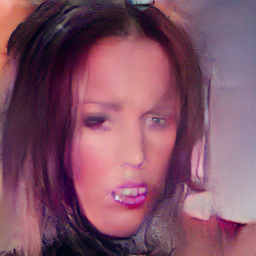

In [ ]:
calculate_sparsity(unet)

Sparsity of Model: 25.07% (68674501/273915936)


: 

In [2]:
!export MODEL_NAME="./run/pruned/ldm_celeba_pruned/pruned"
!export INSTANCE_DIR="./dataset/celeba_hq_256"
!export OUTPUT_DIR="./run/finetuned"

!lora_pti \
  --pretrained_model_name_or_path=$MODEL_NAME  \
  --instance_data_dir=$INSTANCE_DIR \
  --output_dir=$OUTPUT_DIR \
  --train_text_encoder \
  --resolution=256 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --scale_lr \
  --learning_rate_unet=1e-4 \
  --learning_rate_text=1e-5 \
  --learning_rate_ti=5e-4 \
  --color_jitter \
  --lr_scheduler="linear" \
  --lr_warmup_steps=0 \
  --placeholder_tokens="<s1>|<s2>" \
  --use_template="style"\
  --save_steps=100 \
  --max_train_steps_ti=1000 \
  --max_train_steps_tuning=1000 \
  --perform_inversion=True \
  --clip_ti_decay \
  --weight_decay_ti=0.000 \
  --weight_decay_lora=0.001\
  --continue_inversion \
  --continue_inversion_lr=1e-4 \
  --device="cuda:0" \
  --lora_rank=1 \
#  --use_face_segmentation_condition\

2024-10-31 14:37:47.554756: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-31 14:37:47.585622: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-31 14:37:47.585659: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-31 14:37:47.586483: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-31 14:37:47.591284: I tensorflow/core/platform/cpu_feature_guar

2024-10-31 13:57:16.138706: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-31 13:57:16.171759: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-31 13:57:16.171791: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-31 13:57:16.172586: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-31 13:57:16.177893: I tensorflow/core/platform/cpu_feature_guar

Warning! No positional inputs found for a module, assuming batch size is 1.
Warning! No positional inputs found for a module, assuming batch size is 1.
Pruning complete. #Params: 274.0562 M => 165.8026 M
#MACs: 96.0961 G => 55.6929 G
Pruned model saved to pruned_model


  0%|          | 0/100 [00:00<?, ?it/s]

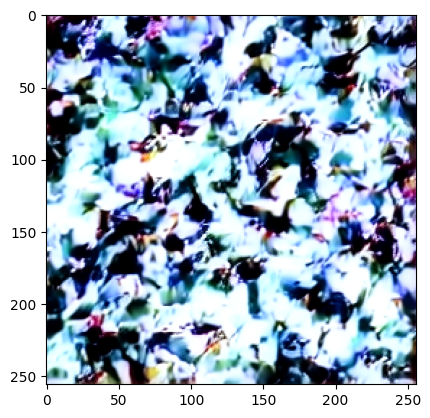

In [1]:
import torch
from diffusers import LDMPipeline, UNet2DModel, VQModel, DDIMScheduler
import torch_pruning as tp
from diffusers.models.attention_processor import Attention
import torchvision
import os
from PIL import Image
import matplotlib.pyplot as plt


# Load pretrained models and scheduler
unet = UNet2DModel.from_pretrained("CompVis/ldm-celebahq-256", subfolder="unet")
vqvae = VQModel.from_pretrained("CompVis/ldm-celebahq-256", subfolder="vqvae")
scheduler = DDIMScheduler.from_config("CompVis/ldm-celebahq-256", subfolder="scheduler")

# Pruning function using torch-pruning's MagnitudePruner
def prune_unet(unet_model, pruning_ratio=0.3, device='cpu'):
    """
    Applies structured pruning to the U-Net model's convolutional layers using the Magnitude Pruner.

    Parameters:
        unet_model (nn.Module): The U-Net model to prune.
        pruning_ratio (float): The proportion of filters to prune in each layer (0 < pruning_ratio < 1).
        device (str): Device to use for pruning, either 'cpu' or 'cuda'.

    Returns:
        nn.Module: The pruned U-Net model.
    """
    example_inputs = {'sample': torch.randn(1, unet_model.in_channels, unet_model.sample_size, unet_model.sample_size).to(device), 
                      'timestep': torch.ones((1,)).long().to(device)}

    imp = tp.importance.MagnitudeImportance(p=1)  # Pruning based on magnitude

    # Define channel groups specifically for attention heads
    channel_groups = {}
    for m in unet_model.modules():
        if isinstance(m, Attention):
            channel_groups[m.to_q] = m.heads
            channel_groups[m.to_k] = m.heads
            channel_groups[m.to_v] = m.heads

    # Define pruner with channel groups to maintain head consistency
    ignored_layers = [unet_model.conv_out]
    pruner = tp.pruner.MagnitudePruner(
        unet_model,
        example_inputs,
        importance=imp,
        iterative_steps=1,
        ch_sparsity=pruning_ratio,
        ignored_layers=ignored_layers,
        channel_groups=channel_groups
    )

    base_macs, base_params = tp.utils.count_ops_and_params(unet_model, example_inputs)
    
    unet_model.eval()
    for group in pruner.step(interactive=True):
        group.prune()

    # Update attributes for compatibility
    from diffusers.models.resnet import Upsample2D, Downsample2D
    for m in unet_model.modules():
        if isinstance(m, (Upsample2D, Downsample2D)):
            m.channels = m.conv.in_channels
            m.out_channels = m.conv.out_channels

    macs, params = tp.utils.count_ops_and_params(unet_model, example_inputs)
    print(f"Pruning complete. #Params: {base_params / 1e6:.4f} M => {params / 1e6:.4f} M")
    print(f"#MACs: {base_macs / 1e9:.4f} G => {macs / 1e9:.4f} G")

    return unet_model

# Set pruning ratio and device
pruning_ratio = 0.2
device = "cuda" if torch.cuda.is_available() else "cpu"

# Move models to device and apply pruning
unet.to(device)
unet = prune_unet(unet, pruning_ratio=pruning_ratio, device=device)

# Initialize and save the pipeline with the pruned U-Net
pipeline = LDMPipeline(
    unet=unet,
    vqvae=vqvae,
    scheduler=scheduler,
).to(device)

save_path = "pruned_model"
os.makedirs(save_path, exist_ok=True)
pipeline.save_pretrained(save_path)
torch.save(unet.state_dict(), os.path.join(save_path, "unet_pruned.pth"))
print(f"Pruned model saved to {save_path}")

# Generate and save a sample image after pruning
with torch.no_grad():
    generator = torch.Generator(device=device).manual_seed(0)
    images = pipeline(num_inference_steps=100, batch_size=1, output_type="numpy").images
    os.makedirs(os.path.join(save_path, 'vis'), exist_ok=True)
    torchvision.utils.save_image(torch.from_numpy(images).permute([0, 3, 1, 2]), f"{save_path}/vis/after_pruning.png")
    
# Show the Image
img = Image.open("pruned_model/vis/after_pruning.png")
plt.imshow(img)
